In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import  torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.optim.lr_scheduler import LinearLR
from torchsummary import summary
from pathlib import Path
from tqdm import tqdm
from PIL import Image

In [15]:
torch.randn((2, 1, 1, 1)).reshape(-1)

tensor([-0.0461,  1.2281])

In [3]:
# Configuration
epochs      = 100
batch_size  = 8
sample_size = 128    # Number of random values to sample
g_lr        = 1.0e-2 # Generator's learning rate
g_wd        = 1.0e-2 # Generator's weights decay
d_lr        = 1.0e-2 # Discriminator's learning rate
d_wd        = 1.0e-2 # Discriminator's weights decay

### Load Dataset

In [4]:
# DataLoader for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True)

### Sanity Check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


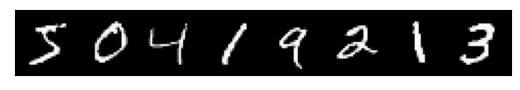

In [5]:
images, labels = next(iter(dataloader))

def show_image_grid(images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Make images into a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last
    image_grid = image_grid.numpy()    # Convert into Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()


show_image_grid(images, ncol=8)

# Generator and Discriminator Architecture

In [6]:
class GeneratorNetworks(nn.Module):
    def __init__(self, latent_dim):
        super(GeneratorNetworks, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28 * 28),  # Output size matches MNIST image (28x28)
            nn.Tanh()  # Tanh activation for image generation
        )
        
        self.latent_dim = latent_dim
        
        self.model_name = 'generator'
        
    def forward(self, batch_size: int):
        z = torch.randn(batch_size, self.latent_dim).cuda()
        img = self.model(z)
        img = img.reshape(batch_size, 1, 28, 28)  # Reshape to MNIST image size
        return img
    
class DiscriminatorNetworks(nn.Module):
    def __init__(self):
        super(DiscriminatorNetworks, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten the input image
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        self.model_name = 'discriminator'
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the input image
        validity = self.model(img_flat)
        return validity

In [7]:
# To save images in grid layout
def save_image_grid(epoch: int, images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'generated_{epoch:03d}.jpg')
    plt.close()

In [8]:
generator = GeneratorNetworks(128).cuda()
discriminator = DiscriminatorNetworks().cuda()

In [16]:
generator.load_state_dict(torch.load('checkpoints/generator.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


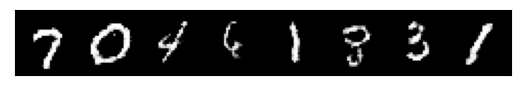

In [26]:
generated_images = generator(batch_size)

show_image_grid(generated_images.cpu(), ncol=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


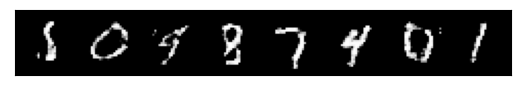

In [11]:
generated_images = generator(batch_size)

show_image_grid(generated_images.cpu(), ncol=8)

In [12]:
class EarlyStopping:
    def __init__(self,
                 max_patience: int,
                 delta: float,
                 checkpoints_dir: Path):
        self.max_patience = max_patience
        self.delta = delta
        self.checkpoints_dir = checkpoints_dir
        self.patience = 0
        self.minimum_loss = None
        
        self.isNeedToStop = False
        self.EARLY_STOPPING_BOUNDARY = 0.3
        self.MINIMUM_LOSS_TO_SAVE_WEIGHTS = 0.1
        
        # create checkpoints directory
        self.checkpoints_dir.mkdir(parents=True, exist_ok=True)
        
    def __call__(self, loss, model, epoch):
        if self.minimum_loss is None:
            self.minimum_loss = loss
        
        elif loss > self.minimum_loss + self.delta:
            
            # if we have current minimum loss is below or equals to EARLY_STOPPING_BOUNDARY
            # then we could trigger the early stopping mechanism
            if self.minimum_loss <= self.EARLY_STOPPING_BOUNDARY:
                self.patience += 1
                print(f'EarlyStopping patience: {self.patience} out of {self.max_patience}')
                if self.patience >= self.max_patience:
                    self.isNeedToStop = True
        else:
            if loss <= self.MINIMUM_LOSS_TO_SAVE_WEIGHTS:
                model_filename = str(f"{model.model_name}_checkpoint_{epoch}.pt")
                self.save_model_weights(loss, model, model_filename)
                
            self.minimum_loss = loss
            self.patience = 0
            
    def save_model_weights(self, current_loss, model, filename):
        torch.save(model.state_dict(), self.path / filename)
        print(f'Validation loss decreased ({self.minimum_loss:.6f} --> {current_loss:.6f}). Saving model...')
                

In [13]:
criterion_D = nn.BCELoss()
criterion_G = nn.MSELoss()

# Initialize optimizers and loss functions
optimizer_G = torch.optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))

scheduler_G = LinearLR(optimizer_G, start_factor=1.0, end_factor=0.5, total_iters=50)
scheduler_D = LinearLR(optimizer_D, start_factor=1.0, end_factor=0.5, total_iters=50)

# Initialize valid and fake labels for adversarial training purposes
valid_labels = torch.ones(batch_size, 1).cuda()
fake_labels = torch.zeros(batch_size, 1).cuda()

earlyStopping = EarlyStopping(max_patience=5,
                             delta=0.05,
                             checkpoints_dir=Path('checkpoints'))

for epoch in range(epochs):
    
    gen_loss_total = 0.0
    disc_loss_total = 0.0
    
    for real_images, _ in dataloader:
        
        real_images = real_images.cuda()
        
        # Train the discriminator first
        optimizer_D.zero_grad()
        
        generated_images = generator(batch_size)
        
        d_loss_real = criterion_D(discriminator(real_images), valid_labels)
        d_loss_fake = criterion_D(discriminator(generated_images), fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        optimizer_D.step()
        
        # Train the generator afterwards
        optimizer_G.zero_grad()
        
        generated_images = generator(batch_size)
        g_loss = criterion_G(discriminator(generated_images), valid_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Accumulate losses
        gen_loss_total += g_loss.item() * batch_size
        disc_loss_total += d_loss.item() * batch_size
        
    # Calculate average losses per epoch
    avg_gen_loss = gen_loss_total / len(dataloader.dataset)
    avg_disc_loss = disc_loss_total / len(dataloader.dataset)
    
    # Print training progress
    print(f"[Epoch {epoch+1}/{epochs}] [G loss: {avg_gen_loss:.4f}] [D loss: {avg_disc_loss:.4f}]")
    
    # Save images
    save_image_grid(epoch+1, generator(batch_size), ncol=8)
    
    # Early Stopping Mechanism for generator avg loss
    earlyStopping(avg_gen_loss, generator, epoch+1)
    
    if earlyStopping.isNeedToStop:
        print("Training Need to be Stopped!")
        break
        

KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), 'checkpoints/generator.pth')
torch.save(discriminator.state_dict(), 'checkpoints/discriminator.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


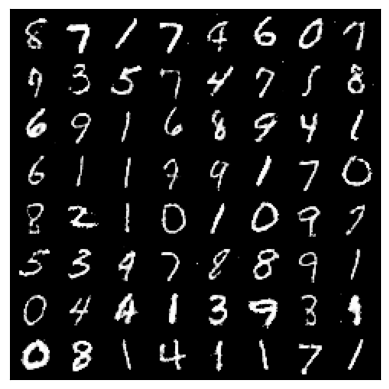

In [ ]:
generated_images = generator(batch_size)

show_image_grid(generated_images.cpu(), ncol=8)

In [ ]:
!zip -r checkpoints.zip checkpoints

updating: checkpoints/ (stored 0%)
updating: checkpoints/generator.pth (deflated 7%)
updating: checkpoints/discriminator.pth (deflated 7%)


### Training Generative Adversarial Networks

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path: Path = 'checkpoints/'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0.2
        
        self.path.mkdir(parents=True, exist_ok=True)

    def __call__(self, d_loss, g_loss, model, model_filename):
        score = -g_loss
        threshold = -d_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            # early stopping will start if the best score is less than 0.3 for the generator
            if self.best_score > -0.3 and threshold > -0.3:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(d_loss, g_loss, model, model_filename)
            self.counter = 0

    def save_checkpoint(self, d_loss, g_loss, model, model_filename):
        if g_loss < self.val_loss_min and d_loss < self.val_loss_min:
            torch.save(model.state_dict(), self.path / model_filename)
            self.val_loss_min = g_loss
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {g_loss:.6f}). Saving model...')


In [ ]:
# Initialize EarlyStopping class
early_stopping = EarlyStopping(patience=5, path=Path('checkpoints'))

criterion = torch.nn.BCEWithLogitsLoss()

d_optimizer = torch.optim.Adam(discriminator_net.parameters(), lr=d_lr)
d_scheduler = LinearLR(d_optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

g_optimizer = torch.optim.Adam(generator_net.parameters(), lr=g_lr)
g_scheduler = LinearLR(g_optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

# Real and fake labels
real_targets = torch.ones(batch_size, 1).cuda()
fake_targets = torch.zeros(batch_size, 1).cuda()

for epoch in range(epochs):
    
    d_losses = []
    g_losses = []
    
    for images, _ in dataloader:
        
        images = images.cuda()
        
        # === Discriminator Networks ===
        # we want to train the discriminator to be good at classifiying generated images
        
        # train the discriminator first
        discriminator_net.train()
        generator_net.eval()
        
        # first calculate the loss of 'real images'
        predictions = discriminator_net(images.reshape(-1, 784))
        d_loss = criterion(predictions, real_targets)
        
        with torch.no_grad():
            generated_images = generator_net(batch_size)
            
        # then, calculate the loss of 'fake images'
        predictions = discriminator_net(generated_images.reshape(-1, 784))
        d_loss += criterion(predictions, fake_targets)
        
        # update the weights
        d_optimizer.zero_grad() # make sure zero grad
        d_loss.backward() # calculate loss
        d_optimizer.step() # update the weights
        d_scheduler.step()
        
        # === Generator Networks ===
        # we want to train the Generator to fool the discriminator
        
        generator_net.train()
        discriminator_net.eval()
        
        # we label the generated images with 'real images'
        generated_images = generator_net(batch_size)
        predictions = discriminator_net(generated_images)
        g_loss = criterion(predictions, real_targets)
        
        # then we update the weights
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        g_scheduler.step()
        
        # Keep losses for logging
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    # Print average losses
    print(f"Epoch[{epoch} / {epochs}], d_losses: {np.mean(d_losses)}, g_losses: {np.mean(g_losses)}")
    
    # Save images
    save_image_grid(epoch, generator_net(batch_size), ncol=8)
    
    # Check if validation loss has improved using EarlyStopping object
    early_stopping(np.mean(d_losses), np.mean(g_losses), generator_net, str(f"generator_model_checkpoint_{epoch}.pt"))
    
    if early_stopping.early_stop:
        print("Early Stopping Executed")
        break

In [ ]:
# generator_net.load_state_dict(torch.load('checkpoints/generator_model_checkpoint_92.pt'))

In [ ]:
# generated_images = generator_net(batch_size)

# show_image_grid(generated_images.cpu(), ncol=8)